In [455]:
# Dubbi:
#1 come mai le chiavi di a sembrano random?
#2 come faccio a non fare re-inserimento ?? Ricorda io estraggo d-1 cosi, più uno, più un altro che è quello di arrivo

In [501]:
import OffsetArrays
using Plots

In [502]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λ = 0.2 #infection rate
d = 5 # degree (fixed for now) 
T = 20 # discrete time
γ = 0.1 # autoinfection probability
N = 1000; #population size

In [503]:
# Creation of the population
# we create μ as the set of all the N functions
# μ[k,ti,ck,τi,σk] is the value taken by the
# function μk with arguments ti,ck,τi,σk
# Using OffsetArrays we managed to keep notation 
# coherent with the notes: 

# i=1,...,N, 
# ti=0,...,T+1 
# c = 0,1
# σ=0,1,2

# The same is done for the ν function later
inizialization = ones(N,T+2,2,T+2,3) / (6*(T+2)^2)
μ = OffsetArrays.OffsetArray(inizialization,0,-1,-1,-1,-1);

In [504]:
#Precalculation of the function a := (1-λ)^{tθ(t)}, 
#useful for later (the function a appears
#  in the inferred time factor node)

a = Dict(zip(-T-2:T+1,[ t<=0 ? 1 : (1-λ)^t for t = -T-2:T+1]));

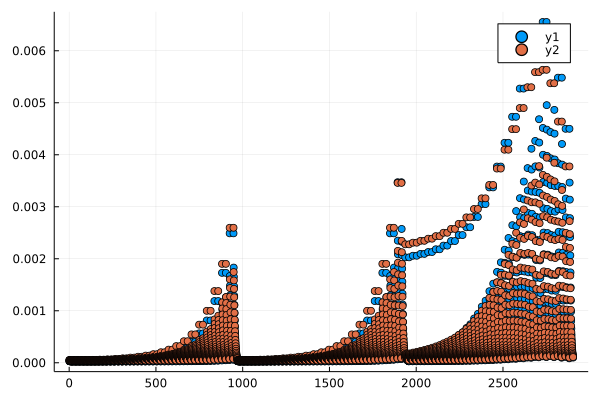

In [574]:
tot_iterations = 500
for iterations = 1:tot_iterations
    # Extraction of disorder: 
    # state of individual i: xi0
    # delays: sij and sji

    sij = floor(Int,log(rand())/log(1-λ)) + 1
    sji = floor(Int,log(rand())/log(1-λ)) + 1
    xi0 = Int(rand() < γ);

    # Initialization of ν=0

    ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    #Extraction of d-1 μ's from population
    neighbours = rand(1:N,d-1)
    # Extraction of the destination node, the dth node
    j = rand(1:N,1);

    #Beginning of calculations:
    # we start by calculating the ν:  
    # it depends on the value of xi0

    if xi0 == 0
        for τi = 0:T+1
            for ti = 0:T+1
                #first we check consistency between
                # the planted time τi and the inferred 
                #time ti by checking the observation constraint            
                if ((ti==T+1)&&(τi<=T)) || ((ti<=T)&&(τi==T+1))  #if the observation is NOT satisfied
                    continue  # ν = 0
                end
                #Since they both depend on ti only,
                # we precaclulate the prior seed probability
                # of the individual and the value of phi function 
                # which is 1 if 0<ti<T+1 and 0 if ti=0,T+1
                seed = (ti==0 ? γ : (1-γ) )
                phi = (ti==0 || ti==T+1) ? 0 : 1
                #now we calculate the four products over
                # μ functions that we need to put in the
                # expression of ν. We call them m1,..,m4
                m1, m2, m3, m4 = ones(4)
                # we initialize the m's to one and then we 
                # loop a product over neighbours
                for k in neighbours 
                    m1 *= sum(μ[k,ti,1,τi,1:2])
                    m2 *= sum(μ[k,ti,0,τi,1:2])
                    m3 *= μ[k,ti,1,τi,2]
                    m4 *= μ[k,ti,0,τi,2]
                end
                #Now we have everything to calculate ν
                for tj=0:T+1                
                    ν[ti,tj,τi,1] = seed * (a[ti-tj-1] * m1 - phi * a[ti-tj] * m2)
                    # We use the fact that ν for σ=2 is just ν at σ=1 plus a term
                    ν[ti,tj,τi,2] = ν[ti,tj,τi,1] + seed * (phi * a[ti-tj] * m4 - a[ti-tj-1] * m3)
                end
            end
        end
    else
        # We are now in the case in which the individual is 
        # the zero patient. In this case the computation of 
        # the ν function is a little bit different than before
        # so we separated the cases

        for τi = 0:T+1
            for ti = 0:T+1
                if ((ti==T+1)&&(τi<=T)) || ((ti<=T)&&(τi==T+1))  #if the observation is NOT satisfied
                    continue
                end
                #we can calculate ν now because it is constant
                # in σ and is nonzero only if tj=0

                #As before we pre-calculate ti-dependent quantities 
                seed = (ti==0 ? γ : (1-γ) )
                phi = (ti==0 || ti==T+1) ? 0 : 1
                # We perform the product over neighbours
                m1, m2 = ones(2)
                for k in neighbours                
                    m1 *= sum(μ[k,ti,1,τi,:])
                    m2 *= sum(μ[k,ti,0,τi,:])
                end
                #We calculate ν in the zero patient case
                ν[ti,0,τi,:] .= seed * (a[ti-1] * m1 - phi * a[ti] * m2)
            end
        end
    end
    if sum(ν) == 0
        println("sum-zero ν")
        return
    end
    ν ./= sum(ν);

    # Now we use the ν vector just calculated to extract the new μ.
    # We extract the index inside the population on which we want to substitute
    # the function μ that we are going to calculate. We call it "l". Now we are going
    # to overwrite the function μ in postition μ[l,:,:,:,:]

    l = rand(1:N);

    # First we calculate and store the cumulated of ν with respect to 
    # planted time, i.e. the third argument. We call Σ this cumulated 

    Σ = cumsum(ν,dims=3);

    for tj = 0:T+1
        for τj = 0:T+1
            #First of all we set to 0 the function we want to update
            #because later we want to sum over it
            μ[l,tj,:,τj,:] .= 0
            for ti = 0:T+1
                #we pre calculate the value of the summed part
                # so not to calculate it twice
                Γ = Σ[ti,tj,clamp(τj+sji-1,0,T+1),2] - Σ[ti,tj,clamp(τj-sij,0,T+1),2]+ν[ti,tj,clamp(τj+sji,0,T+1),1]+
                    Σ[ti,tj,T+1,0] - Σ[ti,tj,clamp(τj+sji,0,T+1),0]
                for c = 0:1
                    μ[l,tj,c,τj,0] += a[tj-ti-c] * Σ[ti,tj,clamp(τj-sij-1,0,T+1),2]
                    μ[l,tj,c,τj,1] += a[tj-ti-c] * Σ[ti,tj,clamp(τj-sij,0,T+1),2]
                    μ[l,tj,c,τj,2] += a[tj-ti-c] * Γ
                end
            end
        end
    end
    μ[l,:,:,:,:] ./= sum(μ[l,:,:,:,:]);          
end
p1 = scatter(reshape(sum(μ,dims=1) ./ N,2904))
p1 = scatter!(reshape(sum(μold,dims=1) ./ N,2904))
#savefig("imageBeautiful.pdf")

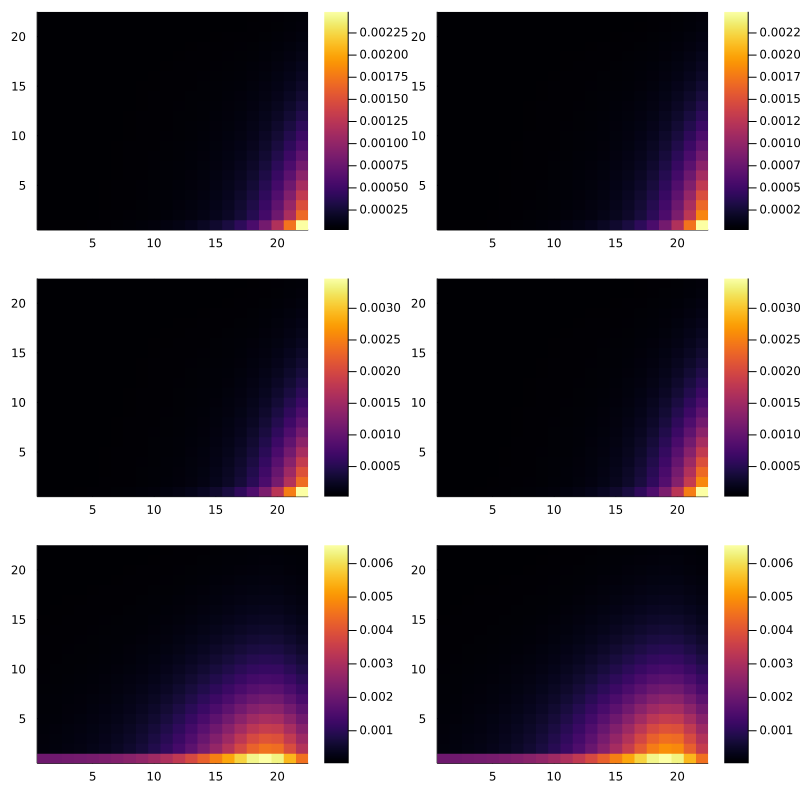

In [576]:
pl1 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,0] ./ N,T+2,T+2))
pl2 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,0] ./ N,T+2,T+2))
pl3 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,1] ./ N,T+2,T+2))
pl4 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,1] ./ N,T+2,T+2))
pl5 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,2] ./ N,T+2,T+2))
pl6 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,2] ./ N,T+2,T+2))

plot(pl1,pl2,pl3,pl4,pl5,pl6,layout = (3,2),size = (800,800))

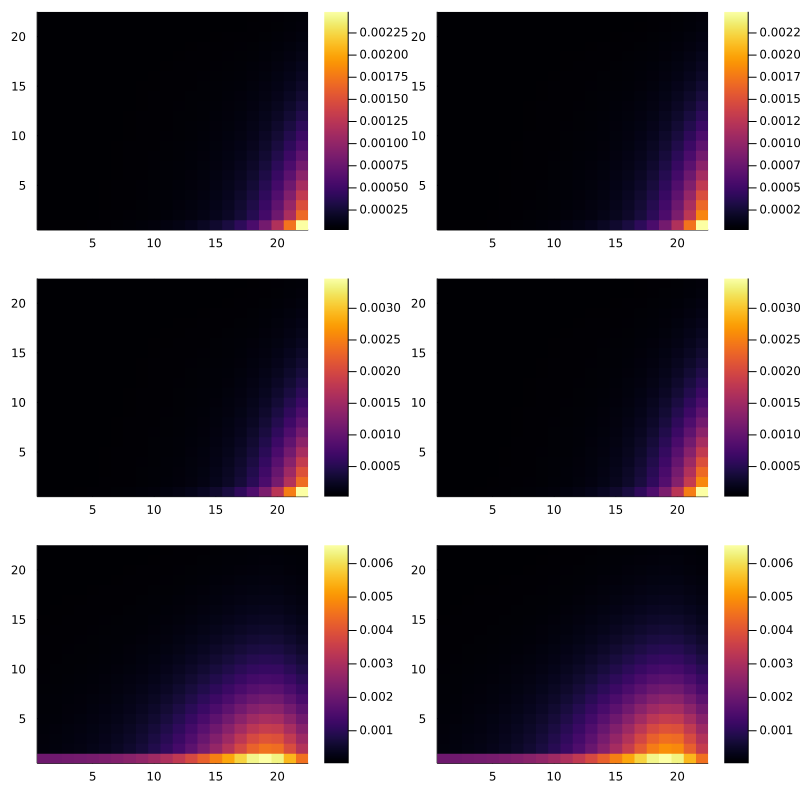

In [577]:
pl1 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,0] ./ N,T+2,T+2))
pl2 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,0] ./ N,T+2,T+2))
pl3 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,1] ./ N,T+2,T+2))
pl4 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,1] ./ N,T+2,T+2))
pl5 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,2] ./ N,T+2,T+2))
pl6 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,2] ./ N,T+2,T+2))

plot(pl1,pl2,pl3,pl4,pl5,pl6,layout = (3,2),size = (800,800))

In [ ]:
μold = copy(μ);